In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load Pandas Dataframe

In [2]:
albums_df = pd.read_pickle("./albums_df_s1.pkl")

### Feature Vectors 

The available feature descriptors are:

- `has_face` that indicates if a **face** is present in the album cover
- `hog_descriptor` that quantifies the **structure** of the image 
- `hsv_hist` that quantifies the **color** of the image
- `lbp_hist` that quantifies the **texture** of the image

### Combining Feature Vectors 

For global feature vectors, we concatenate each feature vector to form a single global feature vector. This approach used in this notebook.


In [3]:
fv_has_face = albums_df.has_face
fv_hog_desc = albums_df.hog_descriptor
fv_hsv_hist = albums_df.hsv_hist
fv_lbp_hist = albums_df.lbp_hist

In [4]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

global_feature =[]

for index in albums_df.index:
    feature_vector = np.hstack([fv_hog_desc[index], fv_hsv_hist[index]])
    global_feature.append(feature_vector)
    
# scaler = MinMaxScaler(feature_range=(0, 1))    
# X = scaler.fit_transform(global_feature)

albums_df['X'] = global_feature

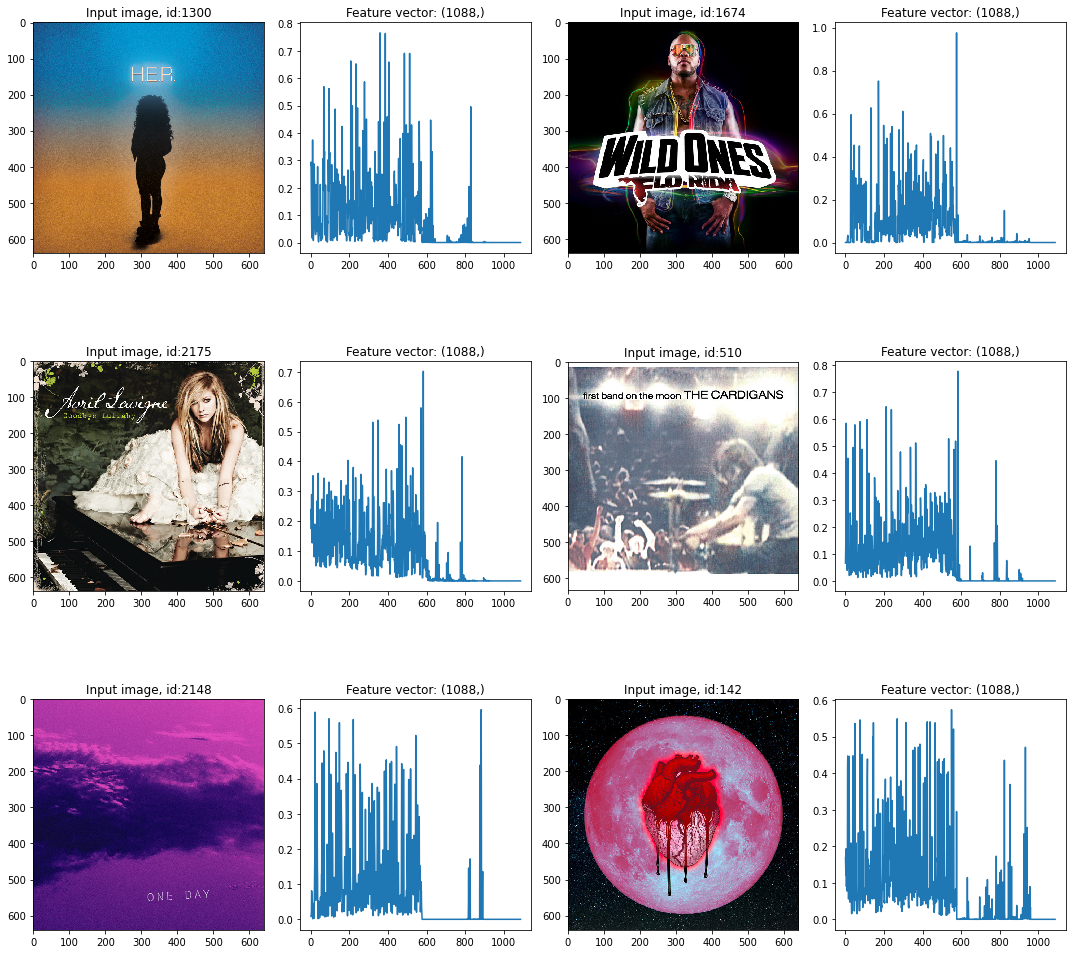

In [5]:
from skimage.io import imread, imshow

image_samples = albums_df.filepath.sample(n = 6, random_state = 42) 
fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 3
hog_no = 0

for plot_number, filepath in enumerate(image_samples):
    image = imread(filepath)
     
    
    ax1 = fig.add_subplot(rows, columns, plot_number+hog_no+1,)
    imshow(image )
    ax1.set_title(f'Input image, id:{albums_df[albums_df.filepath == filepath].index[0]}') 
    
    ax2 = fig.add_subplot(rows, columns, plot_number+hog_no+2,)
    plt.plot(albums_df[albums_df.filepath == filepath].X.values[0])
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)
    ax2.set_title(f"Feature vector: ({albums_df[albums_df.filepath == filepath].X.values[0].size},)")
    
    hog_no+=1
    
plt.show()

## Split the Dataset

The `train_test_split` function provided by `scikit-learn` is used to split the dataset into training and testing data. 

The model will be trained using the training dataset. The split size is decided by the `test_size` parameter, in our case:

- 80% Train Data 
- 20% Test Data

The `stratify` parameter is also used to ensure better class distributions in the training and test set.

In [10]:
from sklearn.model_selection import train_test_split

X = albums_df.X 
y = np.array(['popular' if value > 70 else 'common' for value in albums_df.album_popularity], dtype='object')

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=22,
    stratify=y
)

In [11]:
def transform(X):
    return np.array([x for x in X] )

X_train_prepared = transform(X_train)
X_test_prepared = transform(X_test)

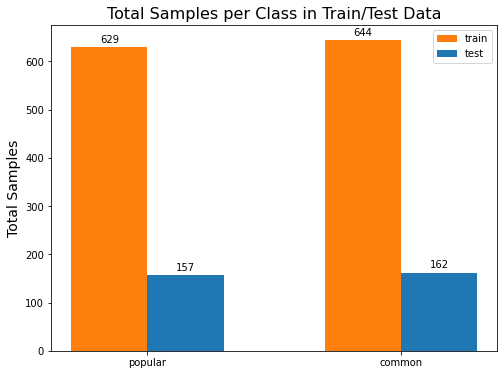

In [13]:
fig, (ax) = plt.subplots(1,1,figsize=(8,6))

labels = ['popular', 'common']
train = list(np.unique(y_train, return_counts=True)[1])
test = list(np.unique(y_test, return_counts=True)[1])

x = np.arange(len(labels))
width = 0.3 

rects1 = ax.bar(x - width/2, train, width, label='train', color = '#ff7f0e')
rects2 = ax.bar(x + width/2, test, width, label='test', color = '#1f77b4')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_ylabel('Total Samples', size = 14)
ax.set_title('Total Samples per Class in Train/Test Data', size = 16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

We classify albums as `popular` if album popularity > 70, `common` otherwise. The classes have common distributions among train and test datasets.

## Cross Validation

Our dataset does not have a decent size to also build a separate validation set to tune the various hyperparameters. 

For this reason, we use the **K-Fold Cross Validation** technique on the training dataset to simulate a validation set.

We choose K = 10, then we split the training data into 9 parts for training and 1 part for testing uniquely over each round upto 10 times. Each model is then trained and evaluated for a given performance metric. Then the 10 values of the chosen metric are averaged to get the final value.

The `StratifiedKFold` method is used. This is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

The following models from `sklearn` are used:

- LogisticRegression
- RandomForestClassifier
- KNeighborsClassifier
- SVM

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from skimage.io import imread, imshow

In [15]:
random_seed = 22
num_trees = 100
scoring = "accuracy"

models = []
models.append(('LR', LogisticRegression(random_state=random_seed, max_iter = 1000)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=random_seed)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(random_state=random_seed)))

In [16]:
results = []
names   = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=random_seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_prepared, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean():.2f} ({cv_results.std():.2f})"
    print(msg)

LR: 0.50 (0.03)
RF: 0.52 (0.05)
KNN: 0.52 (0.04)
SVM: 0.55 (0.03)


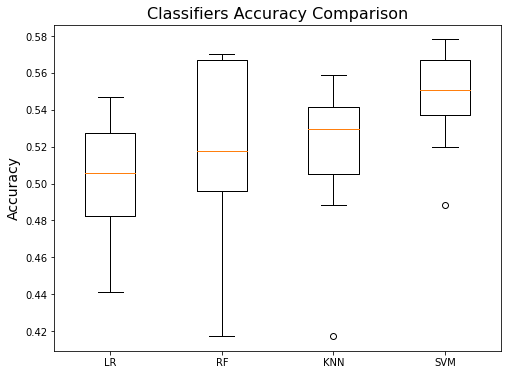

In [17]:
fig, (ax) = plt.subplots(1,1,figsize=(8,6))

plt.boxplot(results)

ax.set_title('Classifiers Accuracy Comparison', size = 16)
ax.set_ylabel('Accuracy', size = 14)
ax.set_xticklabels(names)
plt.show()

## Hyperparameters Tuning

As a tuning technique we use **Grid Search**. For each algorithm we define a different set of hyperparameters to tune, and use the training to train one model for each possible combination of hyperparameters. The performance of each model is assessed, using K-Fold cross validation.

Based on the previous results, we choose the following models to tune:

- RandomForestClassifier
- SVM

In [18]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Random Forest Classifier

The following parameters are tuned:

- number of random features to sample at each split point. Try a range of integer values random, or 1 to half the number of   input features. Try also a suite of different default value calculators.

  **max_features** : `sqrt`, `log2`


- the number of trees 

  **n_estimators** : `10`, `100`, `1000`

In [19]:
model = RandomForestClassifier()

n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

grid = dict(n_estimators=n_estimators,max_features=max_features)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(X_train_prepared, y_train)

# Results
print('-'*65)
print(f"BEST: {grid_result.best_score_:.2f}, params: {grid_result.best_params_}")
print('-'*65)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.2f} ({stdev:.2f}), params: {param}")

-----------------------------------------------------------------
BEST: 0.53, params: {'max_features': 'log2', 'n_estimators': 100}
-----------------------------------------------------------------
0.50 (0.03), params: {'max_features': 'sqrt', 'n_estimators': 10}
0.52 (0.03), params: {'max_features': 'sqrt', 'n_estimators': 100}
0.51 (0.04), params: {'max_features': 'sqrt', 'n_estimators': 1000}
0.50 (0.05), params: {'max_features': 'log2', 'n_estimators': 10}
0.53 (0.06), params: {'max_features': 'log2', 'n_estimators': 100}
0.51 (0.04), params: {'max_features': 'log2', 'n_estimators': 1000}


### SVM

The following parameters are tuned:

- the kernel that controls the manner in which the input variables will be projected. 
  
  **kernel** : `poly`, `rbf`, `sigmoid`


- the penalty C that affects the shape of the resulting regions for each class.

   **C** : `0.001`, `0.1`, `1.0`, `10`, `100`


In [20]:
model = SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [0.001, 0.1, 1.0, 10, 100]
gamma = ['scale']

grid = dict(kernel=kernel,C=C,gamma=gamma)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

grid_result = grid_search.fit(X_train_prepared, y_train)

# Results
print('-'*65)
print(f"BEST: {grid_result.best_score_:.2f}, params: {grid_result.best_params_}")
print('-'*65)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.2f} ({stdev:.2f}), params: {param}")

-----------------------------------------------------------------
BEST: 0.53, params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
-----------------------------------------------------------------
0.51 (0.00), params: {'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}
0.51 (0.00), params: {'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'}
0.51 (0.00), params: {'C': 0.001, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.52 (0.03), params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.51 (0.00), params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.51 (0.00), params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.53 (0.04), params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.53 (0.05), params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.50 (0.04), params: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.51 (0.04), params: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.52 (0.04), params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.50 (0.04), params: {'C': 10, 'gamma': 'scal

## Model Evaluation

Unfortunately the accuracy of our models is not acceptable and further optimization steps should be performed. *(please check Next Steps section)*

For the next steps, we choose to evaluate the Random Forest Classifier model.


BEST: 0.49, params: {'max_features': 'log2', 'n_estimators': 1000}

### Train Model

In [21]:
random_seed = 22

clf = RandomForestClassifier(n_estimators=1000,
                             max_features='log2',
                             random_state=random_seed).fit(X_train_prepared, y_train)

In [230]:
# random_seed = 22

# clf = SVC(C=0.001,
#           gamma='scale', 
#           kernel='poly',
#           random_state=seed).fit(X_train_prepared, y_train)

### Training Set Performance

The training set performance is a strong indicator that our model **overfits** the training dataset.

In [22]:
y_pred = clf.predict(X_train_prepared)

print(classification_report(y_train, y_pred, target_names=['popular', 'common']))

              precision    recall  f1-score   support

     popular       0.98      1.00      0.99       629
      common       1.00      0.98      0.99       644

    accuracy                           0.99      1273
   macro avg       0.99      0.99      0.99      1273
weighted avg       0.99      0.99      0.99      1273



### Test Set Performance

The model is unable to make a useful prediction.

In [23]:
y_pred = clf.predict(X_test_prepared)

print(classification_report(y_test, y_pred, target_names=['popular', 'common']))

              precision    recall  f1-score   support

     popular       0.49      0.50      0.50       157
      common       0.51      0.51      0.51       162

    accuracy                           0.50       319
   macro avg       0.50      0.50      0.50       319
weighted avg       0.50      0.50      0.50       319



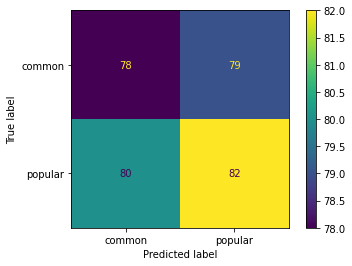

In [24]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test_prepared, y_test)  
plt.show() 

## Plot Predictions

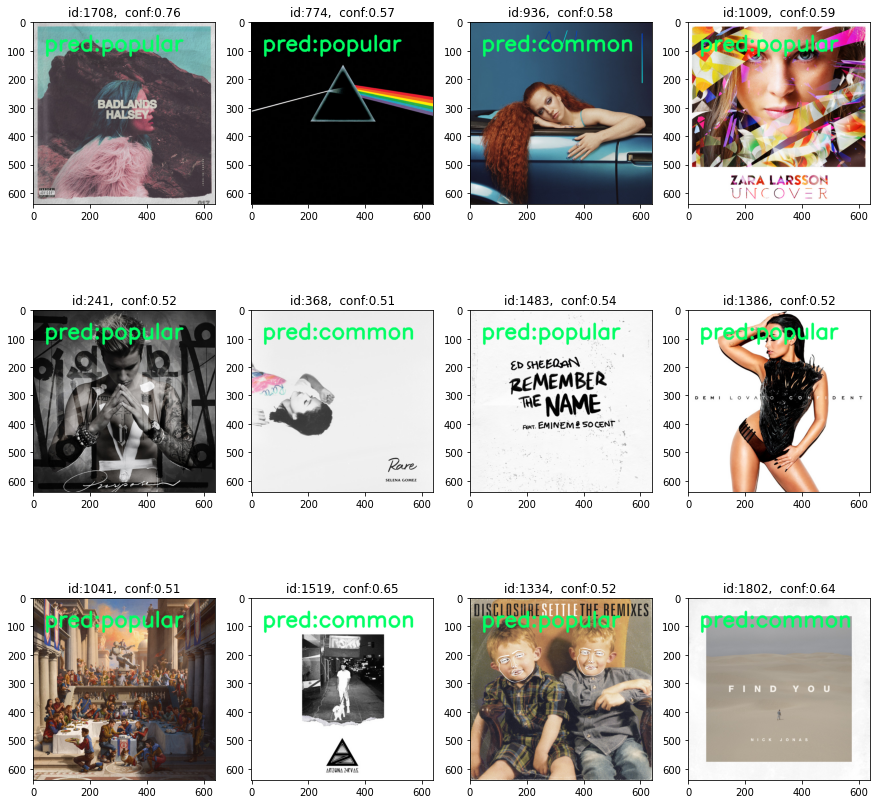

In [36]:
from skimage.io import imread, imshow

fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 3

for i in range(12):
    
    index = X_test.sample().index[0]

    filepath = albums_df.filepath[index]
    image = cv2.imread(filepath)
    
    prediction = pd.Series(clf.predict_proba([X_test[index]]).tolist().pop(), ['popular', 'common'])

    cv2.putText(image, "pred:" + prediction.idxmax() , (40,100), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (100,255,0), 7)
#     cv2.putText(image, "true:" + albums_df.genres[index][0], (40,600), cv2.FONT_HERSHEY_SIMPLEX, 4.0, (0,0,255), 9)
    
    ax1 = fig.add_subplot(rows, columns, i + 1,)
    ax1.set_title(f"id:{index},  conf:{prediction.max():.2f}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  

plt.show()

## Plot Predictions using custom images

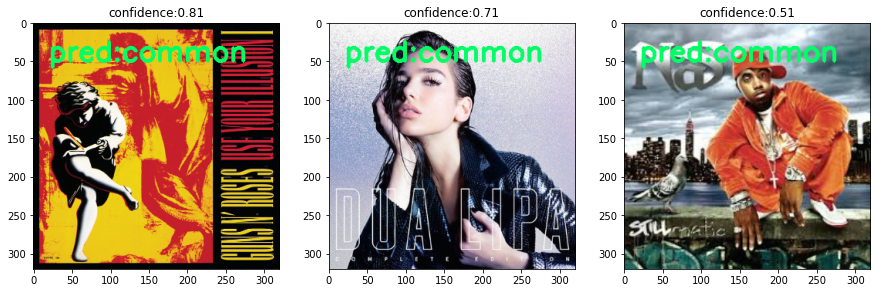

In [37]:
from fd_functions import fd_hog_descriptor, fd_hsv_histogram, fd_local_binary_pattern

filepaths = ['.\\other\\rock2.jpg', '.\\other\\pop1.jpg', '.\\other\\rap1.jpg'  ]
 
fig = plt.figure(figsize=(15, 15))

columns = 3
rows = 1

for i in range(3):
    
    filepath = filepaths[i]
   
    image = imread(filepath)
    fv_1 = fd_hog_descriptor(image)
       
    image = cv2.imread(filepath)
    fv_2 = fd_hsv_histogram(image)
    
    image = cv2.imread(filepath)
    resized = cv2.resize(image, (320,320))
 
    X = np.array(np.append(fv_1,fv_2 ))

    prediction = pd.Series(clf.predict_proba([X]).tolist().pop(), ['popular', 'common'])

    cv2.putText(resized, "pred:" + prediction.idxmax() , (20,50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (100,255,0), 3)
    
    ax1 = fig.add_subplot(rows, columns, i + 1,)
    ax1.set_title(f"confidence:{prediction.max():.2f}")
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))  

plt.show()